In [1]:
import os
import sys
import pandas as pd
import numpy as np
from descartes import PolygonPatch
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.dirname(os.getcwd()))
import alphashape

import pdal
import trimesh
from shapely.geometry import Point, LineString
from scipy import interpolate, spatial
import geopandas as gpd
import networkx as nx

# Borde vía de NP de SR  
## Concavo envolvente de los puntos en 2D de la SR: luego de clasificasdos automáticamente con DL


In [2]:
ppl="""
    {
        "pipeline":[
            "superficiesRodadura/npm3d_parisLille/lille2.ply",
            {
            "type":"filters.decimation",
            "step": 20
            },
            {
            "type":"filters.info"
            }
        ]  
    }"""


#"/mnt/d/8_MSc/GEPMS/3_PavsLiDAR_IC/datasets/NPM3D/paris-lille/training_10_classes/lille2.ply"
# probar con diferentes valores de knn 

pipeline = pdal.Pipeline(ppl)
count = pipeline.execute()

print('numero de puntos de la nube cargada: '+str(count))

numero de puntos de la nube cargada: 590811


In [3]:
#print(pipeline.metadata)

In [4]:
dtst_ini=pipeline.arrays[0]
encbz_ini=pipeline.arrays[0].dtype.names

In [5]:
print('DATOS SUBIDOS CON PDAL\n')
print(encbz_ini)
print(dtst_ini[:3])

DATOS SUBIDOS CON PDAL

('X', 'Y', 'Z', 'scalar_class')
[(-774.49053955, -752.46435547, 27.53279495, 2.0202e+08)
 (-775.38812256, -752.41717529, 27.49207306, 2.0202e+08)
 (-773.76525879, -753.42822266, 27.49519539, 2.0202e+08)]


In [6]:
enc_xy=('X', 'Y')

In [7]:
xy=np.zeros((len(dtst_ini),2))

In [8]:
for e in range(len(xy)):
    for i in range(len(enc_xy)):
        xy[e,i]=dtst_ini[e][encbz_ini.index(enc_xy[i])]

In [9]:
xy.shape

(590811, 2)

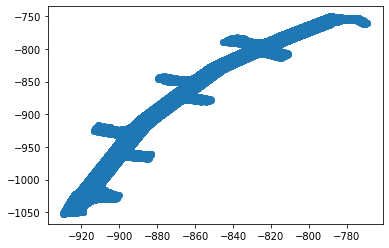

In [10]:
fig, ax = plt.subplots()
ax.scatter(*zip(*xy))
plt.show()

In [11]:
alpha_shape_via = alphashape.alphashape(xy, 2)

In [12]:
#areas=[i.area for i in list(alpha_shape_via.geoms)] -codigo mio
#idxPolMayor=areas.index(max(areas)) -codigo mio
#polyBV=list(alpha_shape_via.geoms)[idxPolMayor] -codigo mio

polyBV = max(alpha_shape_via.geoms, key=lambda x: x.area) #código de ChatGPT

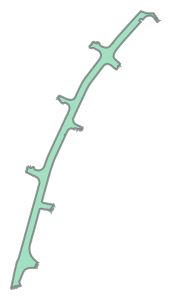

In [13]:
polyBV

/home/xrg/anaconda3/envs/lidgpu_pptk/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


[]

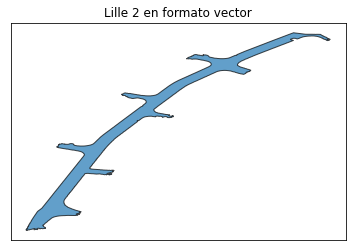

In [14]:
fig, ax = plt.subplots()
ax.add_patch(PolygonPatch(polyBV, alpha=0.7))
ax.set(xticks = [], yticks = [])
#ax.grid(True)
#ax.set_xlabel('Este')
#ax.set_ylabel('Norte')
ax.set_title('Lille 2 en formato vector')
plt.plot()
#plt.savefig('lille2Vector.png')

In [15]:
axis=trimesh.path.polygons.medial_axis(polyBV)

In [16]:
[edg,vert]=axis[0],axis[1]

In [ ]:
edg

In [ ]:
vert

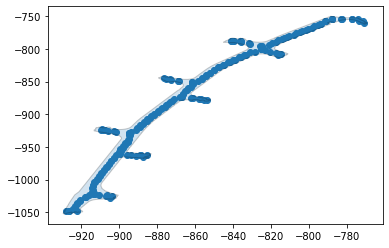

In [17]:
fig, ax = plt.subplots()
ax.scatter(*zip(*vert))
ax.add_patch(PolygonPatch(polyBV, alpha=0.2))
plt.show()

In [ ]:
fig, ax = plt.subplots()
#ax.scatter(vert[0])
plt.plot(vert[0][0], vert[0][1] ,'ro')
ax.add_patch(PolygonPatch(polyBV, alpha=0.2))
plt.show()

In [ ]:
fig, ax = plt.subplots()
#ax.scatter(vert[0])
plt.plot(vert[-1][0], vert[-1][1] ,'ro')
ax.add_patch(PolygonPatch(polyBV, alpha=0.2))
plt.show()

Las últimas dos celdas permiten ver que e orden de los puntos calculados por skeleton no corresponde con el orden geomtetrico necesario para el ejercicio, es decir el inicio y final de la via. Por eso debe usarse matplotlib interactivo.

# matplotlib Interactivo

In [ ]:
%matplotlib widget

In [ ]:
list(enumerate(vert))[0]

In [ ]:
fig, ax = plt.subplots()
ax.scatter(*zip(*vert))
ax.add_patch(PolygonPatch(polyBV, alpha=0.2))

#agregando etiquetas a cada punto: su orden en la lista de vertices.
for eti, coordenadas in enumerate(vert):
    plt.annotate(str(eti), coordenadas)

plt.show()

con esto se identifica que el punto inicial de la via es el 1 y el final el 16. Gracias a esto ahora será posible utilizar networkx para que calcule la ruta entre eso dos puntos.

# probando networkx

In [ ]:
G = nx.cycle_graph(7)

In [ ]:
G[0]

In [ ]:
nx.draw(G)

In [18]:
ggg=nx.from_edgelist(edg)

In [19]:
ggg

In [20]:
print(ggg)

Graph with 196 nodes and 195 edges


In [21]:
eje=list(nx.shortest_simple_paths(ggg, 1, 16)) 

# AQUI ES DONDE SE CALCULA REALMENTE EL EJE, INDICANDO EL PUNTO INICIAL Y EL FINAL.
# ENTONCES ES NECESARIO ENCONTAR UNA ESTRATEGIA QUE PERMITA IDENTIFICAR FACILMENTE CUALES SON ESOS PUNTOS. 

In [ ]:
ejeShapely=LineString(vert[tuple(eje)])

In [ ]:
ejeShapely

In [ ]:
ejsh_sv=ejeShapely.simplify(2, preserve_topology=True)

In [ ]:
ejsh_sv

In [ ]:
fig, ax = plt.subplots()
plt.plot(*ejsh_sv.xy)
ax.add_patch(PolygonPatch(polyBV, alpha=0.2))
plt.show()

In [22]:
x_eje=vert[tuple(eje)][:,0]
y_eje=vert[tuple(eje)][:,1]

In [23]:
tck,u=interpolate.splprep([x_eje,y_eje],s=100)

In [24]:
new_points = interpolate.splev(u, tck)

In [25]:
c_ejsv=np.concatenate((new_points[0].reshape((len(new_points[0]),1)),new_points[1].reshape((len(new_points[1]),1))) ,axis=1)

In [26]:
ejeSuave=LineString(c_ejsv)

In [27]:
ejeSuave.length

350.1815480132809

[]

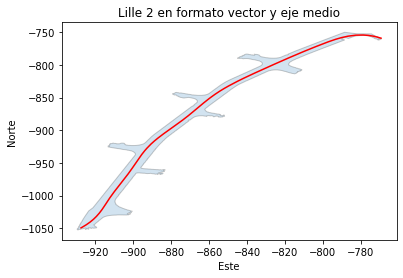

In [28]:
fig, ax = plt.subplots()
plt.plot(*ejeSuave.xy, 'r')
ax.add_patch(PolygonPatch(polyBV, alpha=0.2))
ax.set_xlabel('Este')
ax.set_ylabel('Norte')
ax.set_title('Lille 2 en formato vector y eje medio')
plt.plot()
#plt.savefig('lille2Vector_EjeMedio.png')

In [29]:
p1=ejeSuave.parallel_offset(2.9,'left')
p2=ejeSuave.parallel_offset(1.1,'left')
p3=ejeSuave.parallel_offset(1.1,'right')
p4=ejeSuave.parallel_offset(2.9,'right')

perfiles=[p1,p2,p3,p4]
etiquetas=['Perfil 1', 'Perfil 2', 'Perfil 3', 'Perfil 4']

[]

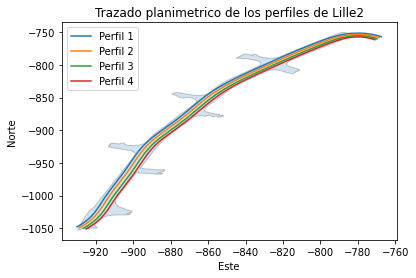

In [30]:
fig, ax = plt.subplots()
#plt.plot(*ejeSuave.xy, label='Eje medio')
for perfil, etiqueta in zip(perfiles, etiquetas):
    plt.plot(*perfil.xy, label=etiqueta)
ax.add_patch(PolygonPatch(polyBV, alpha=0.2))
ax.set_xlabel('Este')
ax.set_ylabel('Norte')
ax.set_title('Trazado planimetrico de los perfiles de Lille2')
plt.legend()
plt.plot()
#plt.savefig('Planimetria_PerfilesLille2.png')
#plt.show()

# aqui


In [ ]:
geoseries_shapely=gpd.GeoSeries(perfiles)
df_shapely=gpd.GeoDataFrame(geoseries_shapely)
df_shapely.columns=['geometry']

In [ ]:
df_shapely

In [ ]:
df_shapely.plot()

In [ ]:
#df_shapely.to_file('shapes/perfilesLille2.shp')

In [ ]:
#ejeSuave=ejeShapely.simplify(8, preserve_topology=False)

In [ ]:
#fig, ax = plt.subplots()
#plt.plot(*ejeSuave.xy)
#ax.add_patch(PolygonPatch(polyBV, alpha=0.2))
#plt.show()

# crear dx

In [31]:
def ptosPerfil(linea, dx):
    # aqui no no coge el ultimo punto de la linea a menos que range sea exacto
    puntos=np.array([np.ravel(np.array(linea.interpolate(i*dx).coords)) for i in range(int(linea.length/dx)+1)]) 
    return puntos

In [32]:
dx=0.25
puntosPerfiles=np.array([ptosPerfil(e,dx) for e in (perfiles)],dtype=object)

In [33]:
puntosPerfiles

array([array([[ -930.08775913, -1047.86797234],
              [ -929.95484992, -1047.65622924],
              [ -929.8219407 , -1047.44448614],
              ...,
              [ -767.89579644,  -756.51330478],
              [ -767.70527762,  -756.67517689],
              [ -767.5147588 ,  -756.837049  ]]),
       array([[ -928.56320883, -1048.82491872],
              [ -928.43029961, -1048.61317562],
              [ -928.29739039, -1048.40143252],
              ...,
              [ -768.99644523,  -757.94012268],
              [ -768.80592641,  -758.10199478],
              [ -768.61540759,  -758.26386689]]),
       array([[ -769.98892285,  -759.98372947],
              [ -770.17944167,  -759.82185736],
              [ -770.36996049,  -759.65998525],
              ...,
              [ -926.41164132, -1049.53533167],
              [ -926.54455054, -1049.74707476],
              [ -926.67745976, -1049.95881786]]),
       array([[ -771.15440202,  -761.35546498],
              [ -771.3449

# Buscando en NP

In [34]:
ppl="""
    {
        "pipeline":[
            "superficiesRodadura/npm3d_parisLille/lille2.ply"
        ]  
    }"""

# probar con diferentes valores de knn 

pipeline = pdal.Pipeline(ppl)
count = pipeline.execute()

In [35]:
print('numero de puntos de la nube cargada: '+str(count))

numero de puntos de la nube cargada: 11816213


In [36]:
dtst_ini=pipeline.arrays[0]
encbz_ini=pipeline.arrays[0].dtype.names

In [37]:
print('DATOS SUBIDOS CON PDAL\n')
print(encbz_ini)
print(dtst_ini[:3])

DATOS SUBIDOS CON PDAL

('X', 'Y', 'Z', 'scalar_class')
[(-774.49053955, -752.46435547, 27.53279495, 2.0202e+08)
 (-774.42498779, -752.54907227, 27.53769302, 2.0202e+08)
 (-774.34057617, -752.64984131, 27.53412437, 2.0202e+08)]


In [38]:
enc_xyzSR=('X', 'Y', 'Z')

In [39]:
xyzSR=np.zeros((len(dtst_ini),3))

In [40]:
for e in range(len(xyzSR)):
    for i in range(len(enc_xyzSR)):
        xyzSR[e,i]=dtst_ini[e][encbz_ini.index(enc_xyzSR[i])]

In [41]:
xyzSR.shape

(11816213, 3)

In [42]:
xySR=xyzSR[:,0:2]
xySR

array([[ -774.49053955,  -752.46435547],
       [ -774.42498779,  -752.54907227],
       [ -774.34057617,  -752.64984131],
       ...,
       [ -929.52288818, -1052.95532227],
       [ -930.0760498 , -1052.54638672],
       [ -930.04248047, -1052.86340332]])

In [43]:
kd=spatial.KDTree(xySR)
kd

In [ ]:
puntosPerfiles

In [44]:
def zFromNubeOrig(nube_orig, kdtree, perfiles, kn):
    z=[]
    for e in perfiles:
        query=kdtree.query(e ,k=kn)
        zp=np.average(nube_orig[query[1]][:,:,-1],axis=1)
        z.append(zp)
    return z

In [49]:
ZZSS=zFromNubeOrig(xyzSR, kd, puntosPerfiles, 50)

In [50]:
def perfz(pfxy,z):
    pft=np.array([np.concatenate((e,np.array(i).reshape(len(i),1)),axis=1) for e,i in zip(pfxy,z)],dtype=object)
    return pft

In [51]:
perfilesConZ=perfz(puntosPerfiles, ZZSS)

In [52]:
p1z=LineString(perfilesConZ[0])
p2z=LineString(perfilesConZ[1])
p3z=LineString(perfilesConZ[2])
p4z=LineString(perfilesConZ[3])
perfiles_Z=[p1z,p2z,p3z,p4z]

In [53]:
geoseries_shapely=gpd.GeoSeries(perfiles_Z)
df_shapely=gpd.GeoDataFrame(geoseries_shapely)
df_shapely.columns=['geometry']

In [54]:
df_shapely

,geometry
0,"LINESTRING Z (-930.088 -1047.868 21.145, -929...."
1,"LINESTRING Z (-928.563 -1048.825 21.177, -928...."
2,"LINESTRING Z (-769.989 -759.984 27.387, -770.1..."
3,"LINESTRING Z (-771.154 -761.355 27.264, -771.3..."


<AxesSubplot:>

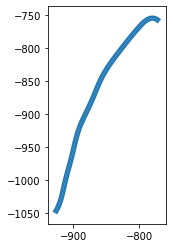

In [55]:
df_shapely.plot()

In [56]:
df_shapely.to_file('shapes/perfilesLille2_Zkn50')

In [57]:
x=[]
for i,e in zip(perfiles, ZZSS):
    x.append(np.array([np.linspace(0,i.length,len(e))]))

In [58]:
ZZSS[-1]=np.flip(ZZSS[-1])
ZZSS[-2]=np.flip(ZZSS[-2])

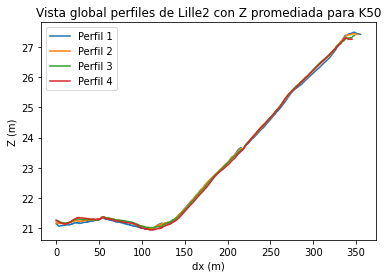

In [59]:
fig, ax = plt.subplots()
for e, i, etq in zip(x,ZZSS, etiquetas):
    plt.plot(e.reshape(e.shape[-1] ,1) ,i, label=etq)
ax.set_xlabel('dx (m)')
ax.set_ylabel('Z (m)')
ax.set_title('Vista global perfiles de Lille2 con Z promediada para K50')
plt.legend()
plt.savefig('PerfilesLille2_k50.png')
#ax.plot(x,zsEjeMedio)

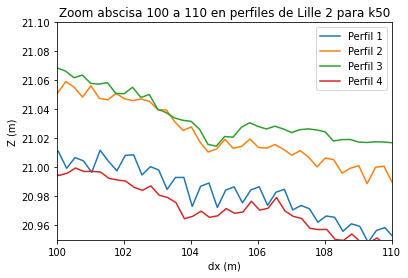

In [60]:
fig, ax = plt.subplots()
for e, i, etq in zip(x,ZZSS, etiquetas):
    plt.plot(e.reshape(e.shape[-1] ,1) ,i, label=etq)
ax.set_xlabel('dx (m)')
ax.set_ylabel('Z (m)')
ax.set_title('Zoom abscisa 100 a 110 en perfiles de Lille 2 para k50')
plt.xlim(100, 110)
plt.ylim(20.95, 21.1)
plt.legend()
plt.savefig('perfsLille2?zoomK50.png')
#ax.plot(x,zsEjeMedio)

In [61]:
ZZSS

[array([21.14502155, 21.14193325, 21.138232  , ..., 27.42519844,
        27.42469501, 27.42387058]),
 array([21.17732719, 21.17536804, 21.1774572 , ..., 27.42334362,
        27.42168938, 27.4194735 ]),
 array([21.25240105, 21.25337379, 21.24767479, ..., 27.38046246,
        27.38388641, 27.38684795]),
 array([21.26490479, 21.25907425, 21.2489164 , ..., 27.26884583,
        27.26701248, 27.26383892])]

In [62]:
qq=[]
for i in ZZSS:
    b=np.array(i).reshape(len(i),1)
    #kk=np.concatenate((a,b), axis=1)
    qq.append(b)
qq

[array([[21.14502155],
        [21.14193325],
        [21.138232  ],
        ...,
        [27.42519844],
        [27.42469501],
        [27.42387058]]),
 array([[21.17732719],
        [21.17536804],
        [21.1774572 ],
        ...,
        [27.42334362],
        [27.42168938],
        [27.4194735 ]]),
 array([[21.25240105],
        [21.25337379],
        [21.24767479],
        ...,
        [27.38046246],
        [27.38388641],
        [27.38684795]]),
 array([[21.26490479],
        [21.25907425],
        [21.2489164 ],
        ...,
        [27.26884583],
        [27.26701248],
        [27.26383892]])]

In [63]:
for e in range(len(qq)):
    DF = pd.DataFrame(qq[e])
    txt='p{}_lille2_ZK50.csv'.format(e+1)
    DF.to_csv(txt)

In [ ]:
DF = pd.DataFrame(zsPerfiles)
DF.to_csv("puntosPerfiles_Lille2_conZFinal.csv")

In [ ]:
DF

# construccion de esqueleto en forma de lineas

In [ ]:
dfs = trimesh.graph.traversals(edg, mode='dfs')
dfs_connected = trimesh.graph.fill_traversals(dfs, edges=edg)

In [ ]:
dfs

In [ ]:
dfs_connected

In [ ]:
lineas=[LineString(vert[i]) for i in dfs_connected]

In [ ]:
lineSmooth=[i.simplify(0.9, preserve_topology=True) for i in lineas]

In [ ]:
for c in lineas:
    plt.plot(*c.xy)
plt.title('Axis ploteo propio irregular')
plt.show()

In [ ]:
for c in lineSmooth:
    plt.plot(*c.xy)
plt.title('Axis ploteo propio suavizado')
plt.show()

In [ ]:
lineas # revisar como paso esto a numpy para revisar cada coordenada

In [ ]:
# !!IMPORTANTE!! asi veo las coords de una linea
np.array(lineSmooth[0].coords)

In [ ]:
import geopandas as gpd

In [ ]:
geoseries_shapely=gpd.GeoSeries(lineSmooth)
df_shapely=gpd.GeoDataFrame(geoseries_shapely)
df_shapely.columns=['geometry']

In [ ]:
df_shapely

In [ ]:
df_shapely.plot()

In [ ]:
df_shapely.to_file('shapes/sekeletonLille2_Suavizado.shp')

# ploteo de solo borde del poligono

In [ ]:
#x_sh, y_sh = alpha_shape_via.geoms[1].exterior.xy
x_sh, y_sh = alpha_shape_via[3].exterior.xy
plt.plot(x_sh, y_sh, c="red")
plt.show()

In [ ]:
x_sh, y_sh = alpha_shape_via.geoms[0].exterior.xy
plt.plot(x_sh, y_sh, c="red")
plt.show()

In [ ]:
list(alpha_shape_via.boundary.coords)

In [ ]:
alpha_shape_via.boundary